<a href="https://colab.research.google.com/github/JanLeyva/CNN/blob/master/MyAssignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# downloading data

%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

second import

In [2]:
# Making necessary imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
FTRAIN = "/content/drive/MyDrive/dataset/training.csv"
FTEST = "/content/drive/MyDrive/dataset/test.csv"

In [5]:
#@title Default title text
# loading data

#FTRAIN = 'training.csv'
#FTEST = 'test.csv'
#FLOOKUP = 'IdLookupTable.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    print("There are missing points:")
    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.   
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [5]:
%%time

train_data = pd.read_csv(FTRAIN)
test_data = pd.read_csv(FTEST)

CPU times: user 2.64 s, sys: 493 ms, total: 3.13 s
Wall time: 7.63 s


In [7]:
%%time

def load_images(image_data):
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [19]:
train_images = load_images(train_data)
train_keypoints = load_keypoints(train_data)

In [8]:
# loading data and checking it

X, y = load()
plot_sample(X[12],y[12])

NameError: ignored

In [11]:
train_images.shape

(4934, 96, 96, 1)

In [13]:
train_keypoints.shape

(2115, 96, 96, 1)

### El problema esta aqui, en cuando utilizamos el train test split!!

No usar

In [10]:
# Split the initial training dataset into training, validation and testing datasets.

train_images, x_test, train_keypoints, y_test = train_test_split(train_images, train_keypoints, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)

ValueError: ignored

# Data augmentation

In [14]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

In [15]:
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 80
BATCH_SIZE = 64

In [20]:
rotated_train_images, rotated_train_keypoints = rotate_augmentation(train_images, train_keypoints)

Augmenting for angles (in degrees): 
12  -12  

In [17]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

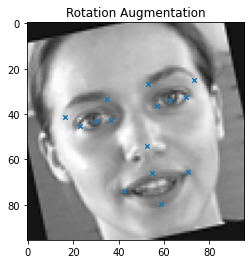

In [21]:
fig, axis = plt.subplots()
plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

In [15]:
train_images = np.concatenate((train_images, rotated_train_images))
train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))

In [16]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

In [17]:
altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(train_images, train_keypoints)

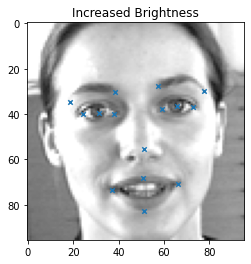

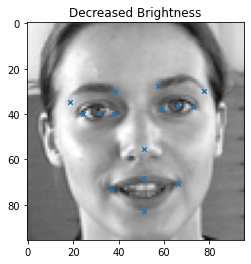

In [18]:
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness")

In [ ]:
train_images = np.concatenate((train_images, altered_brightness_train_images))
train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))

# Performing Horizontal & Vertical shift¶

In [2]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

In [3]:
shifted_train_images, shifted_train_keypoints = shift_images(train_images, train_keypoints)

NameError: ignored

In [ ]:
train_images = np.concatenate((train_images, shifted_train_images))
train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))

# 1st model

In [35]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 96, 96, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1105950   
Total params: 1,143,518
Trainable params: 1,143,518
Non-trainable params: 0
____________________________________________

In [37]:
import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

AttributeError: ignored

In [39]:
batch_size = 128
epochs = 10

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(train_images, train_keypoints, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
149/149 [==============================] - 377s 3s/step - loss: nan - val_loss: nan
Epoch 2/10
149/149 [==============================] - 378s 3s/step - loss: nan - val_loss: nan
Epoch 3/10
149/149 [==============================] - 376s 3s/step - loss: nan - val_loss: nan
Epoch 4/10
 74/149 [=============>................] - ETA: 3:04 - loss: nan

KeyboardInterrupt: ignored